## Scale Data to Prepare it for Model Training

## Setup

### Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
import scipy.stats as stats

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split

## Utility Functions

In [4]:
def train(model: nn.Module, features: torch.Tensor, labels: torch.Tensor, nepochs: int = 100) -> None:
        
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(nepochs):
        optimizer.zero_grad()

        output = model.forward(features)

        loss = loss_function(output, labels)

        loss.backward()

        optimizer.step()

class utils:
    train = train

### Load Data

In [5]:
url = 'https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv'
df = pd.read_csv(url)

# the data in the wine column are the labels
labels = df['Wine'].values

# the data from all other columns are the features
features = df.drop(columns='Wine').values

df

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


Take a look at the numbers in the columns titled `Nonflavanoid.phenols` and `Proline` in the table above. The numbers in the `Nonflavanoid.phenols` are smaller than one while the numbers in the `Proline` column are in the hundreds to one thousand.[<sup>1</sup>](#fn1) When passing the features from this data through a neural network, the data from `Proline` column are going to influence the model more than the data from the `Nonflavanoid.phenols` column, simply because they are bigger. That can negatively impact the performance of the model as the `Proline` data aren't necessarily more important just because the numbers are bigger. To avoid this issue, it's a good idea to make sure that the different features have the same scale, and we can do that through standardizing or normalizing the data. In this notebook, you'll learn different techniques for standardization and normalization. 

<span id="fn1"><sup>1</sup>It's true for the numbers that aren't displayed as well. You can plot them in a histogram to check if you want to. </span>

## Section 1: Scaling of Data Can Improve Network Performance 

There are two common approaches to scaling data: normalization and standardization. Normalization rescales values to a fixed range, typically between 0 and 1, by subtracting the minimum and dividing by the range. Standardization transforms data to have a mean of 0 and a standard deviation of 1 by subtracting the mean and dividing by the standard deviation.

| Code | Description |
| :-- | :-- |
| `(data - data.min())/(data.max()-data.min())` | Normalize data. |
| `(data - data.mean())/data.std()` | Standardize data against mean. |
| `data.mean(axis=0)` or `np.mean(data, axis=0)` | Compute the mean over the first dimension in a multidimensional array. |
| `data.std(axis=0)` or `np.std(data, axis=0)` | Compute the standard deviation over the first dimension in a multidimensional array. |
| `data.min(axis=0)` or `np.min(data, axis=0)` | Compute the minimum over the first dimension in a multidimensional array. |
| `data.max(axis=0)` or `np.max(data, axis=0)` | Compute the maximum over the first dimension in a multidimensional array. |

**Example**: Normalize the `proline` array provided in the cell below. Assign the normalized values to a variable named `norm_proline` and run the cell that plots a distribution of the `norm_proline` to check that its lower bound is `0` and upper bound is `1`.

In [6]:
proline = df['Proline'].values

In [7]:
norm_proline = (proline - proline.min())/(proline.max()-proline.min())

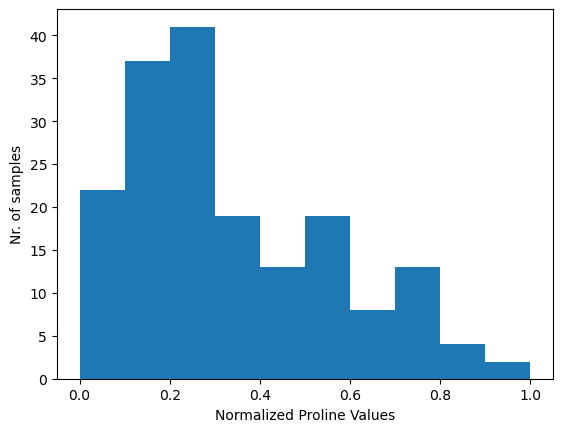

In [8]:
plt.hist(norm_proline)
plt.xlabel('Normalized Proline Values')
plt.ylabel('Nr. of samples');

**Exercise**: Normalize the `Nonflavanoid.phenols` data, which are assigned to the variable `non_ph` in the cell below. Assign the normalized values to a variable named `norm_non_ph` and run the cell that plots a distribution of the `norm_non_ph` to check that its lower bound is `0` and upper bound is `1`.

In [9]:
non_ph = df['Nonflavanoid.phenols'].values

norm_non_ph = (non_ph - non_ph.min())/(non_ph.max()-non_ph.min())

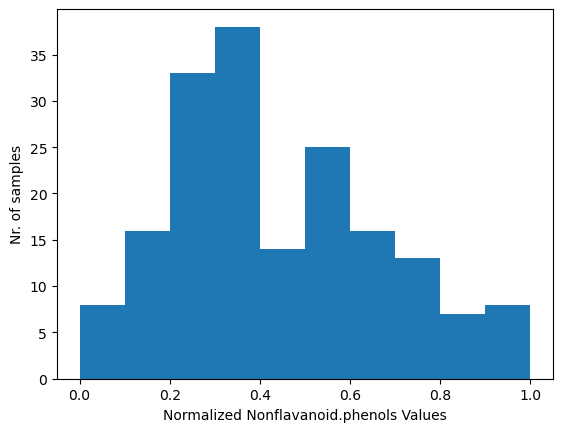

In [10]:
plt.hist(norm_non_ph)
plt.xlabel('Normalized Nonflavanoid.phenols Values')
plt.ylabel('Nr. of samples');

**Exercise**: Compute the normalized values of `features` provided below, which contains the data from both the `Proline` and the `Nonflavanoid.phenols` column. Assign the result to a variable named `norm_features` and run the cell making a boxplot for the two features after normalization to check that they are both bounded by `0` and `1`.

**Hint**: You need to specify the axis along which the `min` and the `max` should be calculated - e.g. `axis=0`.

In [11]:
features = df[['Proline','Nonflavanoid.phenols']].values

In [12]:
norm_features = (features - features.min(axis=0))/(features.max(axis=0)-features.min(axis=0))

Text(0, 0.5, 'Normalized Values')

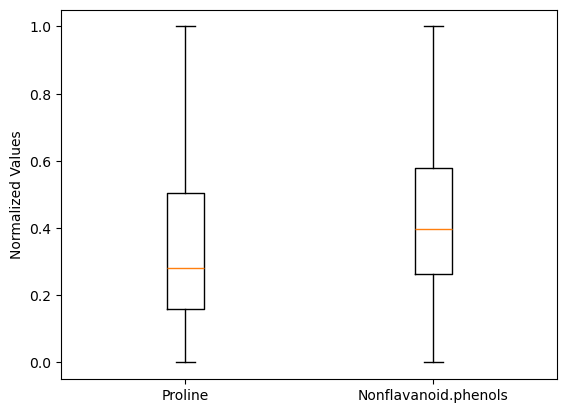

In [13]:
plt.boxplot(norm_features)
plt.xticks([1, 2], ['Proline', 'Nonflavanoid.phenols'])
plt.ylabel('Normalized Values')

**Exercise**: Compute the normalized values of the array `features` provided below, which contains the data from **all columns** except the `Wine` column. Assign the result to a variable named `norm_features` and run the cell making a boxplot for all features after normalization to check that all 13 features are bounded by `0` and `1`.

In [14]:
# the data from all other columns are the features
features = df.drop(columns='Wine').values

In [15]:
norm_features = (features - features.min(axis=0))/(features.max(axis=0)-features.min(axis=0))

Text(0, 0.5, 'Normalized Values')

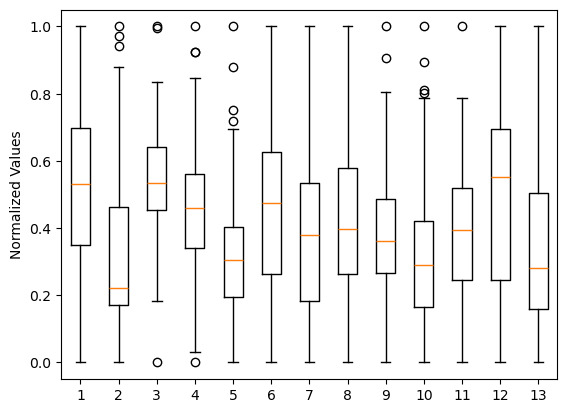

In [16]:
plt.boxplot(norm_features)
plt.ylabel('Normalized Values')

#### Demo: Effect of Normalization on Model Performance

Run the cells below and compare the accuracy of the model when trained with the original, non-normalized data to the accuracy when trained with normalized data.

In [17]:
# the data from all other columns are the features
features = df.drop(columns='Wine').values

# convert to tensors (labels 0-indexed for CrossEntropyLoss)
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels - 1, dtype=torch.long)

# create dataset and split
dataset = TensorDataset(features_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], 
                                            generator=torch.Generator().manual_seed(2026))

# save indices for reuse with normalized features
train_indices = train_dataset.indices
test_indices = test_dataset.indices

# extract tensors
features_train = features_tensor[train_indices]
labels_train = labels_tensor[train_indices]
features_test = features_tensor[test_indices]
labels_test = labels_tensor[test_indices]

Create model

In [18]:
n_features = features_train.shape[1]
n_classes = len(torch.unique(labels_train))

model = nn.Sequential(
    nn.Linear(n_features, 200),
    nn.ReLU(),
    nn.Linear(200, n_classes)
)

Train model

In [19]:
utils.train(model, features_train, labels_train, nepochs=50)

with torch.no_grad():
    predictions = model(features_test).argmax(dim=1)
    accuracy_nonnorm = (predictions == labels_test).float().mean().item()

print(f'Accuracy without normalization = {accuracy_nonnorm:.2f}')

Accuracy without normalization = 0.69


In [20]:
features_norm = MinMaxScaler().fit_transform(features)

# Convert to tensor and use same split indices
features_norm_tensor = torch.tensor(features_norm, dtype=torch.float32)
features_norm_train = features_norm_tensor[train_indices]
features_norm_test = features_norm_tensor[test_indices]

In [21]:
n_features = features_norm_train.shape[1]
n_classes = len(torch.unique(labels_train))

mlp_norm = nn.Sequential(
    nn.Linear(n_features, 200),
    nn.ReLU(),
    nn.Linear(200, n_classes)
)

utils.train(mlp_norm, features_norm_train, labels_train, nepochs=50)

with torch.no_grad():
    predictions = mlp_norm(features_norm_test).argmax(dim=1)
    accuracy_norm = (predictions == labels_test).float().mean().item()

print(f'Accuracy with normalization = {accuracy_norm:.2f}')

Accuracy with normalization = 0.92


Text(0, 0.5, 'Accuracy (%)')

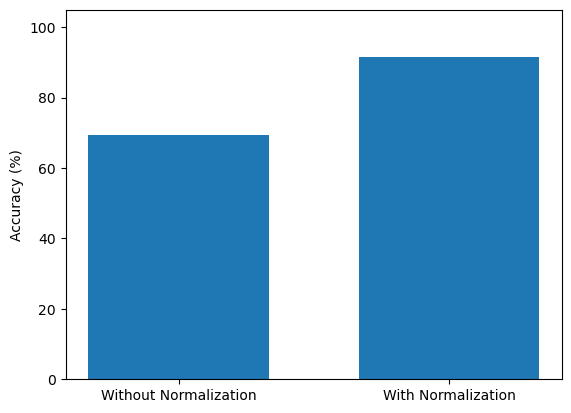

In [22]:
plt.bar([0,0.3], np.array([accuracy_nonnorm, accuracy_norm])*100, width=[0.2])
plt.xticks([0,0.3], labels=['Without Normalization', 'With Normalization'])
plt.ylim([0.,105])
plt.ylabel('Accuracy (%)')

The model performance improved by more than 15 percentage points simply by normalizing the features!

**Exercise**: *Standardize* the `alcohol` array provided in the cell below. Assign the standardized values to a variable named `z_alcohol` and run the cell that plots a distribution of the `z_alcohol` to do a rough visual check of whether it's a normal distribution or not (i.e. bell curve centered around 0).

**Hint**: Remember that standardization is not the same as normalization.

In [23]:
alcohol = df['Alcohol'].values

In [24]:
z_alcohol = (alcohol - alcohol.mean())/alcohol.std()

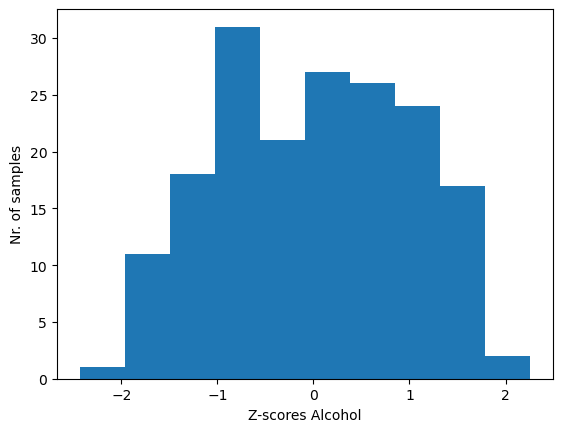

In [25]:
plt.hist(z_alcohol)
plt.xlabel('Z-scores Alcohol')
plt.ylabel('Nr. of samples');

**Exercise**: *Standarize* the `malic` array provided in the cell below. Assign the standardized values to a variable named `z_malic` and run the cell that plots a distribution of the `z_malic` to do a rough visual check of whether it's a normal distribution or not (i.e. bell curve centered around 0).

In [26]:
malic = df['Malic.acid'].values

In [27]:
z_malic = (malic - malic.mean())/malic.std()

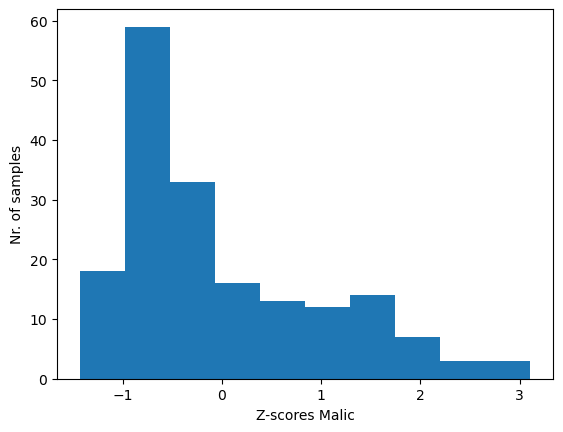

In [28]:
plt.hist(z_malic)
plt.xlabel('Z-scores Malic')
plt.ylabel('Nr. of samples');

## Section 2: `sklearn.preprocessing` Has Functions for Scaling

The `sklearn.preprocessing` module provides ready made classes that handle scaling for you. These classes also remember the scaling parameters (like the minimum, maximum, mean, and standard deviation) so you can apply the same transformation to new data later or reverse the transformation to get back the original values.

| Code | Description |
|---|---|
| `StandardScaler().fit_transform(data)` | Standardize the data. It subtracts the mean and divides by the standard deviation. |
| `RobustScaler().fit_transform(data)` | Standardize the data using the median and interquartile range. Reduces effect of outliers. |
| `MinMaxScaler().fit_transform(data)` | Normalize data using the range between the minimum and maximum value. |
| `StandardScaler().inverse_transform(standardized_data)` | Gets the original data back from the standardized data. |
| `MinMaxScaler().inverse_transform(normalized_data)` | Gets the original data back from the normalized data. |


#### **Exercises**


**Example**: Use the appropriate class from `sklearn.preprocessing` to normalize the `proline` data provided in the cell below.

 Assign the normalized values to a variable named `norm_proline` and run the cell that plots a distribution of the `norm_proline` to check that its lower bound is `0` and upper bound is `1`.

In [29]:
proline = df['Proline'].values.reshape(-1,1)

In [30]:
norm_proline = MinMaxScaler().fit_transform(proline)

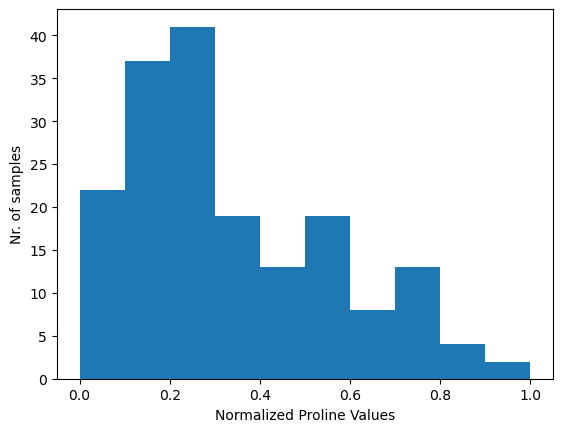

In [31]:
plt.hist(norm_proline)
plt.xlabel('Normalized Proline Values')
plt.ylabel('Nr. of samples');

**Exercise**: Use the appropriate class from `sklearn.preprocessing` to normalize the `malic` data provided in the cell below.

 Assign the normalized values to a variable named `norm_malic` and run the cell that plots a distribution of the `norm_malic` to check that its lower bound is `0` and upper bound is `1`.

In [32]:
malic = df['Malic.acid'].values.reshape(-1,1)

In [33]:
norm_malic = MinMaxScaler().fit_transform(malic)

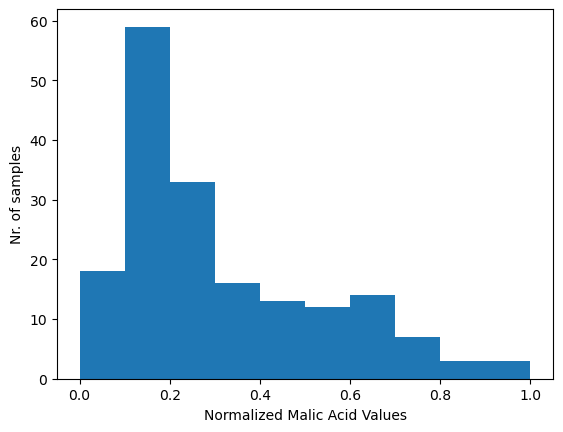

In [34]:
plt.hist(norm_malic)
plt.xlabel('Normalized Malic Acid Values')
plt.ylabel('Nr. of samples');

**Exercise**: Use the appropriate class from `sklearn.preprocessing` to **standardize** the `alcohol` data provided below. The mean and standard deviation should be used to standardize.

 Assign the standardized values to a variable named `z_alcohol` and run the cell that plots a distribution of the `z_alcohol` to check that its midpoint is roughly at 0.

In [35]:
alcohol = df['Alcohol'].values.reshape(-1,1)

In [36]:
z_alcohol = StandardScaler().fit_transform(alcohol)

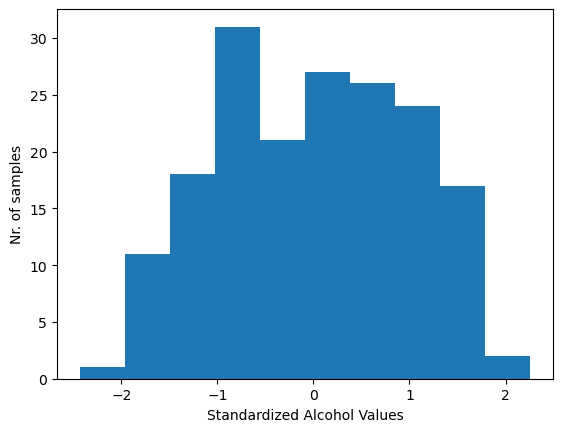

In [37]:
plt.hist(z_alcohol)
plt.xlabel('Standardized Alcohol Values')
plt.ylabel('Nr. of samples');

**Exercise**: Use the appropriate class from `sklearn.preprocessing` to **standardize** the `magnesium` data provided below. The median and interquartile range should be used to standardize.

 Assign the normalized values to a variable named `z_mg` and run the cell that plots a distribution of the `z_mg` to check that the **peak** of the distribution is roughly at 0.

In [38]:
magnesium = df['Mg'].values.reshape(-1,1)

In [39]:
z_mg = RobustScaler().fit_transform(magnesium)

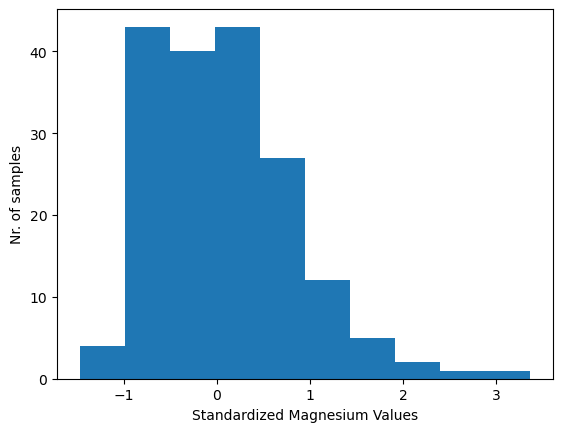

In [40]:
plt.hist(z_mg)
plt.xlabel('Standardized Magnesium Values')
plt.ylabel('Nr. of samples');

**Exercise**: Use the appropriate class from `sklearn.preprocessing` to **normalize** the `features` variable provided below, which contains data from all columns except the `Wine` column.

Assign the result to a variable named `norm_features` and run the cell making a boxplot for all features after normalization to check that all 13 features are bounded by `0` and `1`.

In [41]:
features = df.drop(columns = 'Wine')
features

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [42]:
norm_features = MinMaxScaler().fit_transform(features)

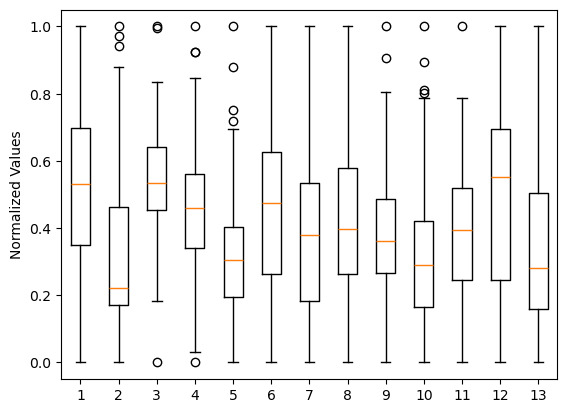

In [43]:
plt.boxplot(norm_features)
plt.ylabel('Normalized Values');

`sklearn.preprocessing` offers functions to get the original data back from the normalized or standardized data as well.

**Exercise**: Use the appropriate class from `sklearn.preprocessing` to get the original data back from the normalized proline data in `norm_proline` provided below.

Assign the result to a variable named `proline` and run the cell that plots a histogram of `proline` to verify that the original values have been recovered.

In [44]:
scaler = MinMaxScaler()
norm_proline = scaler.fit_transform(df['Proline'].values.reshape(-1,1))

In [45]:
proline = scaler.inverse_transform(norm_proline)

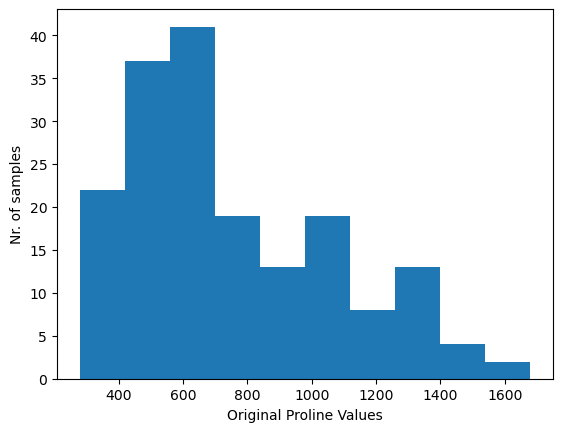

In [46]:
plt.hist(proline)
plt.xlabel('Original Proline Values')
plt.ylabel('Nr. of samples');

## Section 3: The Type of Scaling Should be Picked Wisely

In the last exercise above, you may have observed that the standardized scores for the `Malic.acid` data **do not** (appear to) follow a normal distribution. In that case, standardization is not appropriate because standarization assumes a normal distribution. In this section, you'll learn how to determine what kind of distribution your data have and what scaling measure you should choose.

| Code | Description |
| :-- | :-- |
| `stats.probplot(data, dist="norm", plot=plt)` | Creates a Q-Q plot comparing the distribution of the data against a normal distribution. |
| `statistic, p_value = stats.shapiro(data)` | Shapiro-Wilk test for normality of `data`. |
| `stats.iqr(data)` | Calculate the interquartile range. |
| `(data - np.median(data))/stats.iqr(data)` | Standardize `data` against median and interquartile range. |

**Example**: Make a Q-Q plot of the data in the `Alcohol` column. Does the data appear to be approximately normally distributed - do the blue dots generally track the red line? Which scaling does that suggest that we should use?

In [47]:
alcohol = df['Alcohol'].values

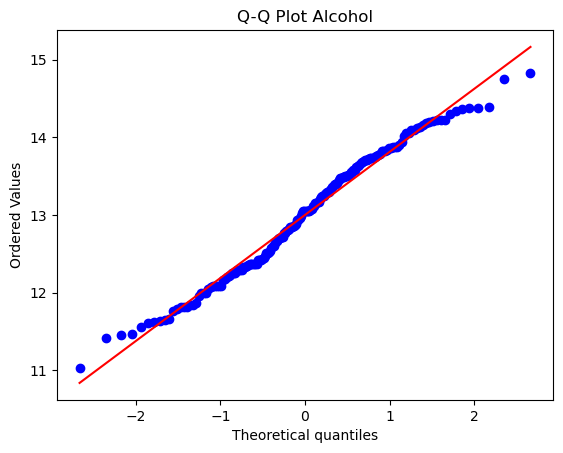

In [48]:
stats.probplot(alcohol, dist="norm", plot=plt)
plt.title("Q-Q Plot Alcohol");

**Answer**: The data generally tracks the red line, which suggests that it's normally distributed and that we can use standardization with mean and the standard deviation for the alcohol data.

**Exercise**: Make a Q-Q plot of the data in the `Malic.acid` column. Does the data appear to be approximately normally distributed - do the blue dots generally track the red line? Which scaling does that suggest that we should use?

In [49]:
malic = df['Malic.acid'].values

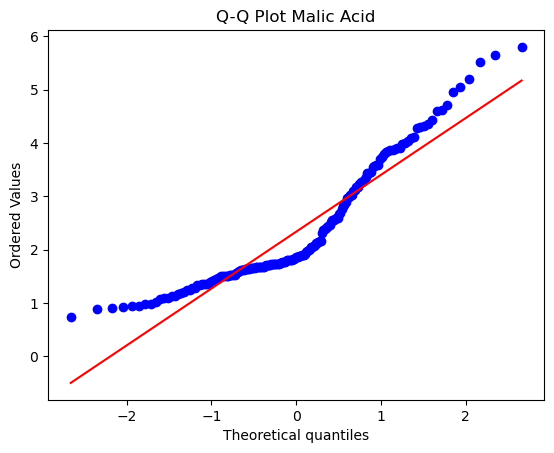

In [50]:
stats.probplot(malic, dist="norm", plot=plt)

plt.title("Q-Q Plot Malic Acid");

# The data is not normally distributed and normalization should be used rather than standardization

**Exercise**: Make a Q-Q plot of the data in the `Mg` column. How does it compare to the Q-Q plot for the `Alcohol` data?

In [51]:
magnesium = df['Mg'].values

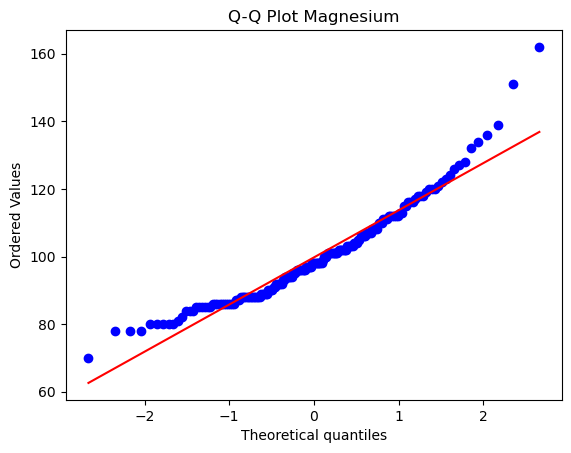

In [52]:
stats.probplot(magnesium, dist="norm", plot=plt)

plt.title("Q-Q Plot Magnesium");

Q-Q plot is a good visual check of the distribution in addition to looking at the histogram, but it's a good idea to use it in combination with a statistical test of normality, the Shapiro-Wilk test. 

The Shapiro-Wilk test tests the null hypothesis that the sample data was drawn from a normally distributed population. If the test-statistic is close to 1 (higher than 0.95) and statistically significant, the data is probably drawn from normal distribution. If the test-statistic is below 0.9, it's probably not drawn from a normal distribution. Between 0.9 and 0.95 is an edge case.

**Exercise**: Do a Shapiro-Wilk test on the `alcohol` data. Print the statistic and the p-value. Do the results of the test suggest that it is normally distributed? Can we scale the `alcohol` data using standardization?

In [53]:
alcohol = df['Alcohol'].values

In [ ]:
statistic, p_value = stats.shapiro(alcohol)
statistic, p_value

# test-statistic > 0.95

(np.float64(0.9818041416927711), np.float64(0.020047981728854945))

**Exercise**: Do a Shapiro-Wilk test on the `malic` data. Print the statistic and the p-value. Do the results of the test suggest that it is normally distributed? Which scaling should we use?

In [53]:
malic = df['Malic.acid'].values

In [ ]:
statistic, p_value = stats.shapiro(malic)
statistic, p_value

# test-statistic < 0.9

(np.float64(0.8887839752895415), np.float64(2.945800703600761e-10))

**Exercise**: Do a Shapiro-Wilk test on the `magnesium` data. Print the statistic and the p-value. Do the results of the test suggest that it is normally distributed?

In [55]:
statistic, p_value = stats.shapiro(magnesium)
statistic, p_value
# test-statistic between 0.9 and 0.95 is an edge case

(np.float64(0.9383312109016513), np.float64(6.345693783266514e-07))

**Demo**: The distribution of the `Mg` data is a bit of an edge case. Below, the `Mg` data is plotted using a boxplot and a histogram. It appears to be approximately normally distributed between 75 and 125, but it's skewed to the right and has outliers at the upper end of the distribution. In this case, using the **median** and **interquartile range** (IQR) instead of the mean and the standard deviation is a better choice if you standardize. Because they are less sensitive to outliers. In other words, the `RobustScaler` in `sklearn` is more appropriate than the `StandardScaler`.

Text(0, 0.5, 'Number of Samples')

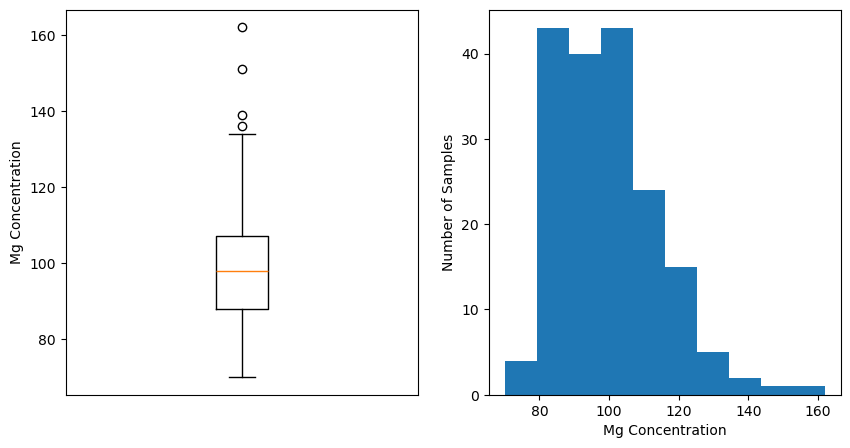

In [56]:
fig, axes = plt.subplots(ncols=2, figsize = (10,5))

axes[0].boxplot(df['Mg'].values)
axes[0].set_xticks([])
axes[0].set_ylabel('Mg Concentration')
axes[1].hist(df['Mg'].values);
axes[1].set_xlabel('Mg Concentration')
axes[1].set_ylabel('Number of Samples')

**Exercise**: Standardize the `magnesium` data **using the median** and the **Inter-quartile Range (IQR)** instead of the mean and the standard deviation. Then, run the cell creating the boxplot to check that the median (the orange line at the notch) is centered (approximately) at 0.

In [57]:
magnesium = df['Mg'].values.reshape(-1,1)

In [58]:
z_magnesium = RobustScaler().fit_transform(magnesium)

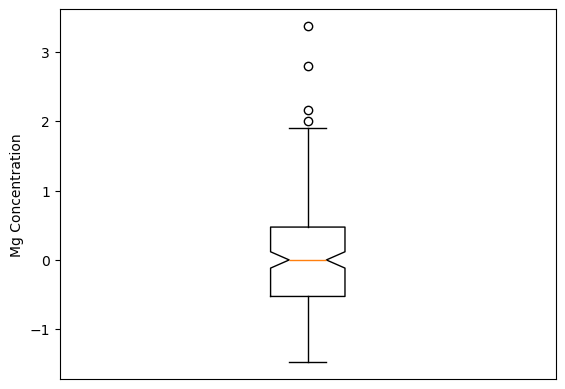

In [59]:
plt.boxplot(z_magnesium, notch=True)
plt.xticks([])
plt.ylabel('Mg Concentration');

As we have seen above, some of the features in the dataset are normally distributed, some are normal distributions with outliers, some are not normally distributed. What do we do if we want to use all features in our dataset when they have different distributions? In that case, the safest choice is to use normalization (`MinMaxScaler` in `sklearn.preprocessing`), as that doesn't violate assumptions of normality for those features that aren't normally distributed.

## Section 4: How to Handle Categorical Variables: One-hot Encoding for Features and Label Encoding

Neural networks require numerical input, but many datasets contain categorical variables (like country names, colors, or categories). This section covers how to convert categorical data into numerical format suitable for training.

| Code | Description |
| :-- | :-- |
| `LabelEncoder().fit_transform(data)` | Convert categorical labels to integers. Use for target **labels**, not features. |
| `OneHotEncoder().fit_transform(data)` | Convert categories to binary columns (one column per category). Use for categorical **features**. |
| `data.values.reshape(-1,1)` | Reshape a 1D array to a 2D column vector (required by `OneHotEncoder`). |
| `encoded.toarray()` | Convert output from `OneHotEncoder` to a `NumPy` array. |
| `np.hstack([array1, array2])` | Horizontally stack arrays to combine encoded features with other data. |

#### Exercises

Run the cell below to generate synthetic data used in this section.

In [60]:
np.random.seed(2026)
country = ['France', 'France', 'Italy', 'Georgia', 'Greece', 'Spain']
wine = ['Merlot', 'Cabernet Sauvignon', 'Baralo', 'Saperavi', 'Naousa', 'Ribera del Duero']
soil_type = ['Gravel', 'Limestone', 'Chalk', 'Clay', 'Volcanic', 'Loam']
price = np.random.randint(20, 71, len(wine),)

data = {
        'Wine': wine,
        'Country': country,
        'Soil_type': soil_type,
        'Price': price
}
df = pd.DataFrame(data)
df

,Wine,Country,Soil_type,Price
0,Merlot,France,Gravel,21
1,Cabernet Sauvignon,France,Limestone,26
2,Baralo,Italy,Chalk,46
3,Saperavi,Georgia,Clay,33
4,Naousa,Greece,Volcanic,33
5,Ribera del Duero,Spain,Loam,49


**Example**: Use `LabelEncoder` to create encoded target labels for the car brands below. Assign the result to a variable named `car_labels`. Run the cell that creates a DataFrame of the encoded labels and the original car brands to see them side by side.

In [61]:
cars = ['BMW', 'Volkswagen', 'Toyota', 'Rolls Royce', 'Saab', 'Volvo']

In [62]:
car_labels = LabelEncoder().fit_transform(cars)

In [63]:
pd.DataFrame({'Car': cars, 'Encoded': car_labels})

,Car,Encoded
0,BMW,0
1,Volkswagen,4
2,Toyota,3
3,Rolls Royce,1
4,Saab,2
5,Volvo,5


**Exercise**: Use `LabelEncoder` to create encoded target labels for the `wines` data below. Assign the result to a variable named `wine_labels`. Run the cell that creates a DataFrame of the the encoded labels and the original wine names to see them side by side.

In [64]:
wines = df['Wine']

In [65]:
wine_labels = LabelEncoder().fit_transform(wines)

In [66]:
pd.DataFrame({'Wine': df['Wine'], 'Encoded': wine_labels})

,Wine,Encoded
0,Merlot,2
1,Cabernet Sauvignon,1
2,Baralo,0
3,Saperavi,5
4,Naousa,3
5,Ribera del Duero,4


**Exercise**: Use the `OneHotEncoder` to create a onehot encoding of the feature `countries` below. Assign the result to a variable named `countries_onehot`. Run the cell that creates a DataFrame of the onehot encoded countries and the original country names to see them side by side.

In [67]:
countries = df['Country'].values.reshape(-1,1)

In [68]:
countries_onehot = OneHotEncoder().fit_transform(countries)

In [69]:
pd.DataFrame(np.hstack([df['Country'].values.reshape(-1,1), countries_onehot.toarray()]))

,0,1,2,3,4,5
0,France,1.0,0.0,0.0,0.0,0.0
1,France,1.0,0.0,0.0,0.0,0.0
2,Italy,0.0,0.0,0.0,1.0,0.0
3,Georgia,0.0,1.0,0.0,0.0,0.0
4,Greece,0.0,0.0,1.0,0.0,0.0
5,Spain,0.0,0.0,0.0,0.0,1.0


**Exercise**: Use `OneHotEncoder` to encode the `soil_type` column in the dataframe `df`. Assign the result to a variable named `soil_onehot`. Run the cell that creates a DataFrame of the onehot encoded soil types and the original soil types to see them side by side.

In [70]:
soil_types = df['Soil_type'].values.reshape(-1,1)

In [71]:
soil_onehot = OneHotEncoder().fit_transform(soil_types)

In [72]:
pd.DataFrame(np.hstack([df['Soil_type'].values.reshape(-1,1), soil_onehot.toarray()]))

,0,1,2,3,4,5,6
0,Gravel,0.0,0.0,1.0,0.0,0.0,0.0
1,Limestone,0.0,0.0,0.0,1.0,0.0,0.0
2,Chalk,1.0,0.0,0.0,0.0,0.0,0.0
3,Clay,0.0,1.0,0.0,0.0,0.0,0.0
4,Volcanic,0.0,0.0,0.0,0.0,0.0,1.0
5,Loam,0.0,0.0,0.0,0.0,1.0,0.0


Label encoding assigns each category a unique integer (e.g., France=0, Italy=1, Spain=2). This works well for **target labels** but not for **features** because it implies an ordering (Italy > France), which doesn't make sense here unless you want to imply that Italian wine is better than French wine.

One-hot encoding creates a binary column for each category. For a "Country" feature with France, Italy, and Spain, it creates three columns where each row has a 1 in exactly one column. This avoids implying a misleading order between categories.